In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Encoder

In [2]:
encoder_training_info = np.load('encoder_training_info.npy', allow_pickle=True).item()

In [3]:
from utils import fit_powerlaw
from utils import step_to_compute

def plot_compute_vs_metric(
    meta_info,
    model_base,
    metric,
    dataset_list,
    color_list,
    sizes = ['1K', '10K', '100K', '300K', '1M', '3M', '10M', '30M', '100M', '300M'],
    stride=None,
    fit=True,
    figsize=(8, 6),
    ylabel=None,
    minbias=0,
    yticks=None,
    y_max=None
):    
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    ax.set_xscale('log')
    
    minys = []
    maxys = []
    lines = []
    labels = []
    for dataset, colors in zip(dataset_list, color_list):
        
        x2y = {}
        yss = []
        for size in sizes:
            model_name = f'{model_base}_{size}_16B'
            if model_name not in meta_info.keys():
                continue
            
            xs = step_to_compute(size)
            ys = meta_info[model_name][dataset][metric][:, 1]
            yss.append(ys)
            logxs = np.log10(xs)
            logys = np.log10(ys)
            
            ax.plot(xs, logys, c=colors[0], linestyle='-', alpha=0.2, linewidth=2)
            
            for x_, y_ in zip(logxs, logys):
                rx = round(x_, 1)
                if rx not in x2y:
                    x2y[rx] = y_
                else:
                    x2y[rx] = min(x2y[rx], y_)
            
        sorted_x2y = dict(sorted(x2y.items()))
        logxs = np.array(list(sorted_x2y.keys()))
        logys = np.array(list(sorted_x2y.values()))
        xs = 10**logxs
        ys = 10**logys
        
        ax.plot(xs, logys, c=colors[0], linestyle='-', linewidth=2)
        
        if dataset == 'lsf':
            prefix = r'OOD-LSF: '
        elif dataset == 'monash':
            prefix = r'OOD-Monash: '
        else:
            prefix = r'ID: '
        
        if fit:
            logys_fit, label = fit_powerlaw(xs, ys, signal='C')
            line, = ax.plot(xs, logys_fit, c=colors[1], linestyle='--', label=prefix + label, linewidth=4)
            lines.append(line)
            labels.append(label)

        minys.append(np.min(yss))
        maxys.append(np.max(yss))
        
    miny, maxy = min(minys), max(maxys)
    if stride is None:
        if maxy - miny < 0.5:
            stride = 0.1
        elif maxy - miny < 1:
            stride = 0.2
        elif maxy - miny < 10:
            stride = 1
        elif maxy - miny < 100:
            stride = 10
        elif maxy - miny < 1000:
            stride = 100
        else:
            stride = 1000
        
    if y_max is not None:
        maxy = y_max
        
    ax.set_ylim(np.log10(miny-minbias), np.log10(maxy+stride))
   
    yticks = np.arange(miny-minbias, maxy+stride, stride) if yticks is None else yticks
    ax.set_yticks(np.log10(yticks), [f'{yt:.1f}' for yt in yticks])
    
    ax.set_xlabel('Compute [PF-days]')
    
    ylabel = metric if ylabel is None else ylabel
    ax.set_ylabel(ylabel)

    ax.legend(loc='lower left', borderaxespad=0.1, ncol=1, frameon=True)
        
    ax.grid(which='both', axis='y', linestyle='--', linewidth=0.5)
    for xtick in [10**(-i) for i in range(4,11)]:
        ax.axvline(x=xtick, color='gray', linestyle='--', linewidth=0.5)

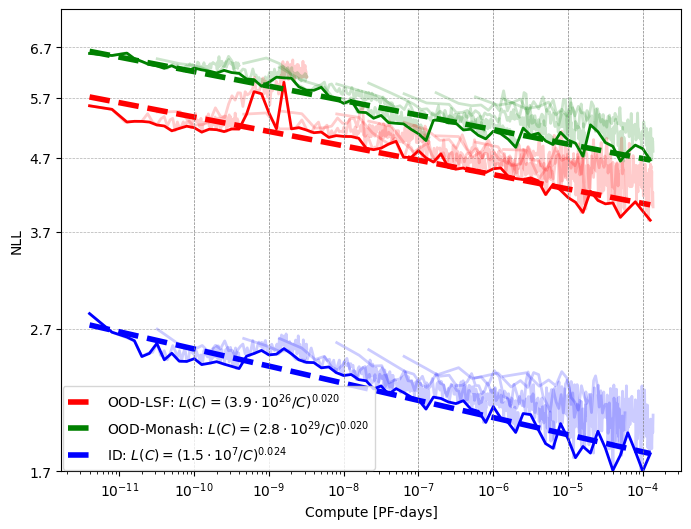

In [4]:
plot_compute_vs_metric(
    encoder_training_info,
    'encoder',
    'PackedNLLLoss',
    ['lsf', 'monash', 'val'],
    [['red', 'red'], ['green', 'green'], ['blue', 'blue']],
    ylabel='NLL'
)

# Decoder

In [5]:
decoder_training_info = np.load('decoder_training_info.npy', allow_pickle=True).item()

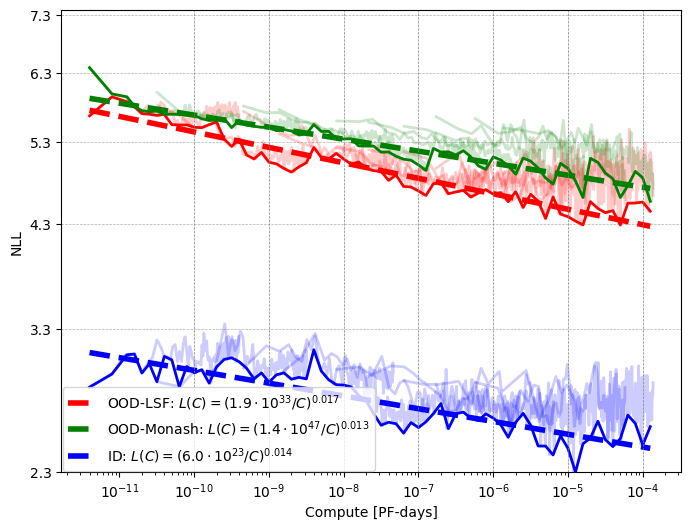

In [6]:
plot_compute_vs_metric(
    decoder_training_info,
    'decoder',
    'PackedNLLLoss',
    ['lsf', 'monash', 'val'],
    [['red', 'red'], ['green', 'green'], ['blue', 'blue']],
    ylabel='NLL'
)